<a href="https://colab.research.google.com/github/Govind-Pillai/Statistics_Tasks/blob/main/Task_7_12_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,classification_report
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [3]:
df = pd.read_csv("/content/loan_approved.csv")

# New Section

In [4]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status (Approved)
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
df.describe()


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [6]:
df.isnull().mean()

,0
Loan_ID,0.000000
Gender,0.021173
Married,0.004886
Dependents,0.024430
Education,0.000000
Self_Employed,0.052117
ApplicantIncome,0.000000
CoapplicantIncome,0.000000
LoanAmount,0.035831
Loan_Amount_Term,0.022801


Since none of the features exceed 50 percent of the total null value we cannot drop any columns.

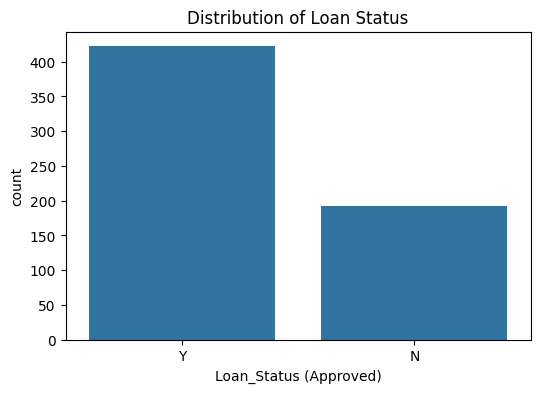

In [7]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Loan_Status (Approved)', data=df)
plt.title('Distribution of Loan Status')
plt.show()

Text(0.5, 0.98, 'Histograms of Numerical Features')

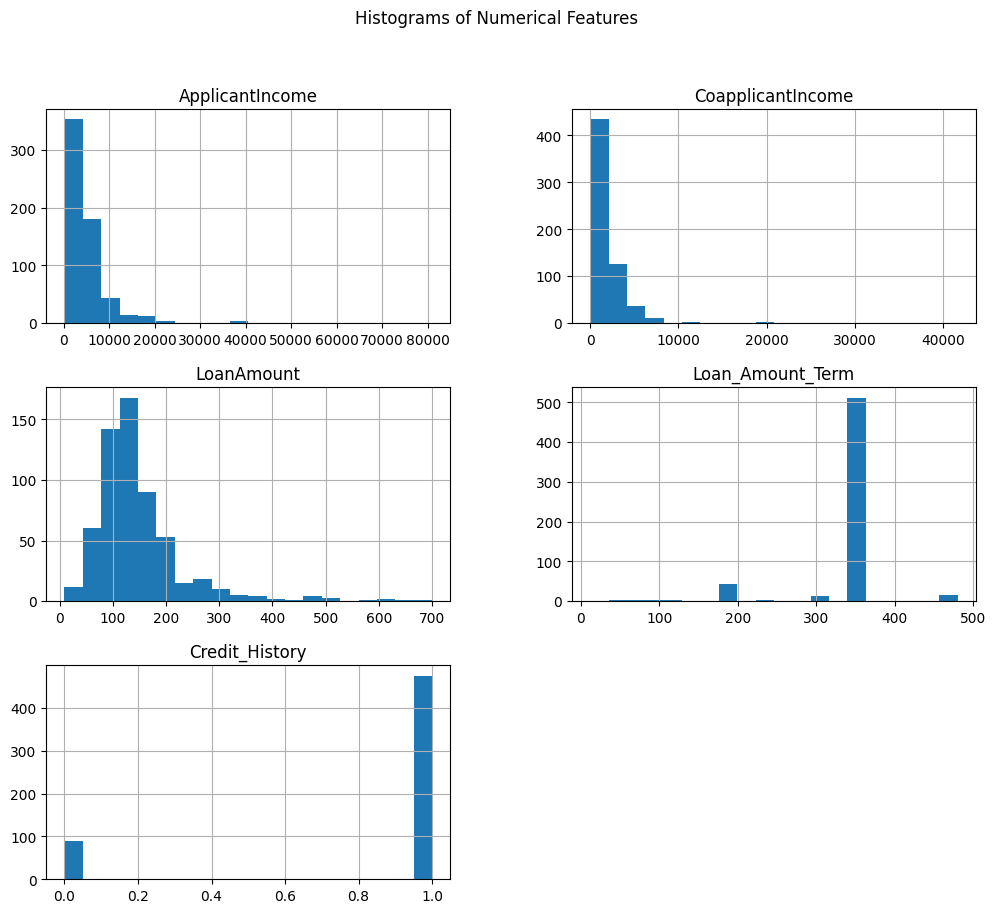

In [8]:
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols].hist(figsize=(12, 10), bins=20)
plt.suptitle('Histograms of Numerical Features')

In [9]:
cat_cols = df.select_dtypes(include='object').columns
# Remove Loan_ID as it's an identifier and Loan_Status as it is target
cat_cols = [c for c in cat_cols if c not in ['Loan_ID', 'Loan_Status (Approved)']]

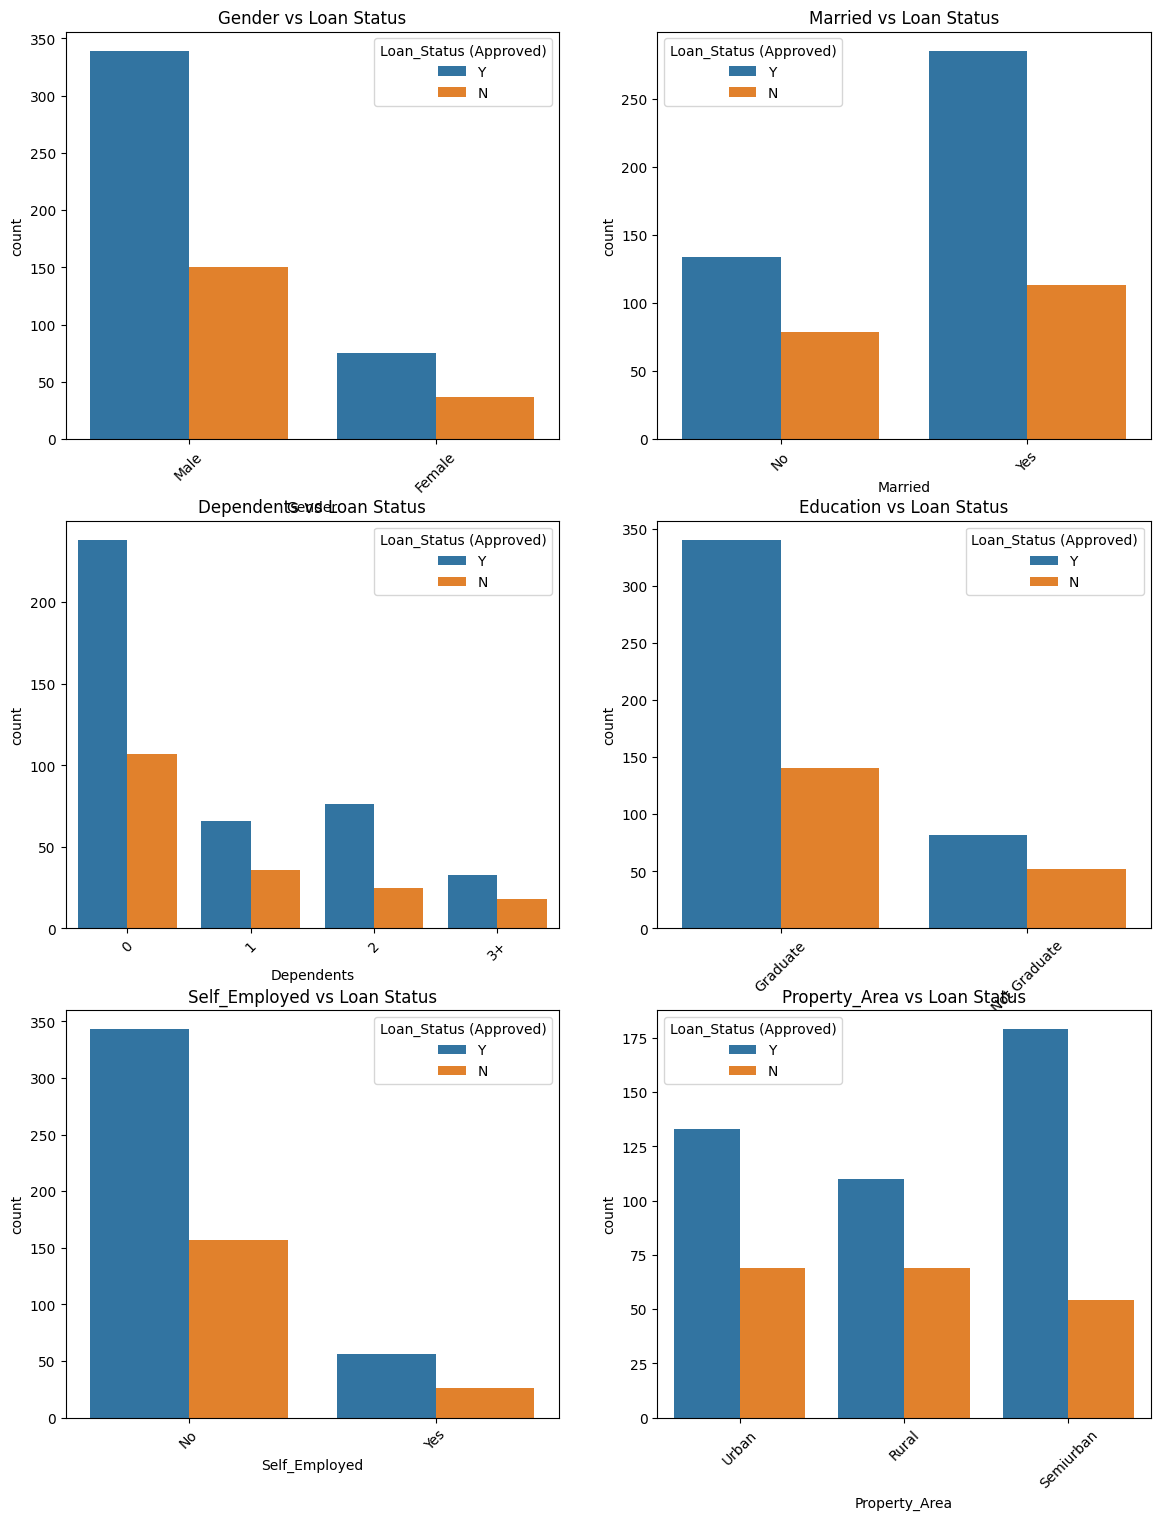

In [10]:
fig, axes = plt.subplots(nrows=len(cat_cols)//2 + len(cat_cols)%2, ncols=2, figsize=(14, 18))
axes = axes.flatten()
for i, col in enumerate(cat_cols):
    sns.countplot(x=col, hue='Loan_Status (Approved)', data=df, ax=axes[i])
    axes[i].set_title(f'{col} vs Loan Status')
    axes[i].tick_params(axis='x', rotation=45)

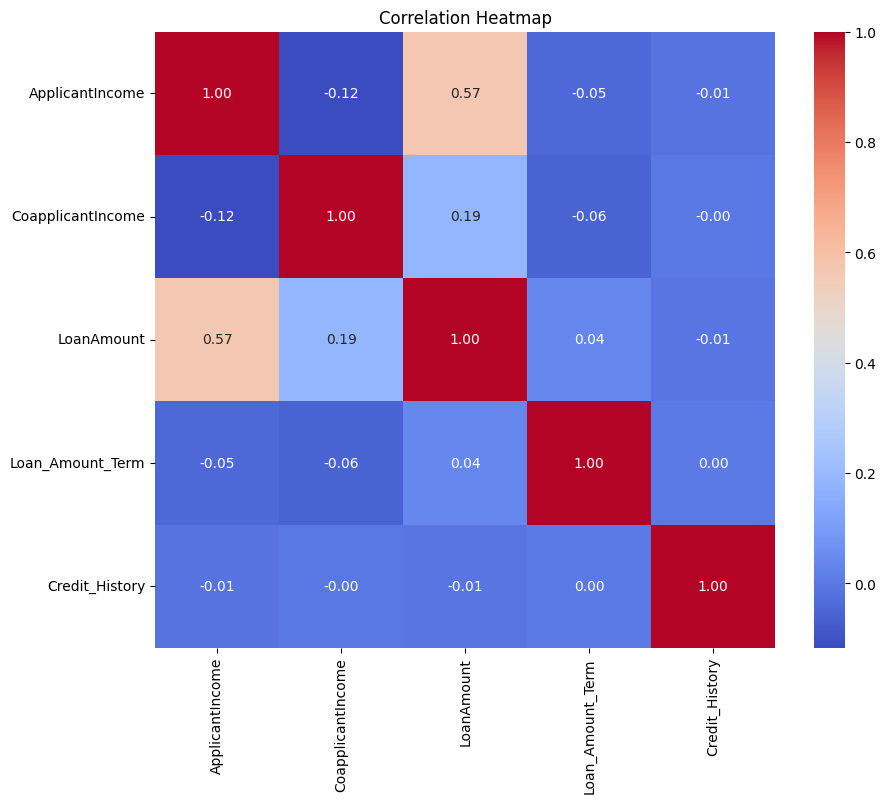

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png')

In [20]:
X = df.drop(columns=['Loan_ID', 'Loan_Status (Approved)'])
y = df['Loan_Status (Approved)']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 3. Define Features types
numeric_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

# 4. Create Preprocessing Pipeline
# Numeric: Impute missing values with median -> Standardize
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical: Impute missing values with most frequent -> OneHotEncode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse=False for PCA compatibility
])

# Combine
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 5. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# 6. Define Models
models = {
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(),
    'Naive Bayes': GaussianNB()
}

results = []

for name, model in models.items():
    # Create full pipeline: Preprocessor -> PCA -> Model
    # Note: PCA is applied after preprocessing
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=0.95)), # Keep 95% variance
        ('classifier', model)
    ])

    # Train
    clf.fit(X_train, y_train)

    # Predict
    y_pred = clf.predict(X_test)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, pos_label=1) # 1 is likely 'Y' (Approved)
    prec = precision_score(y_test, y_pred, pos_label=1)
    rec = recall_score(y_test, y_pred, pos_label=1)

    results.append({
        'Model': name,
        'Accuracy': acc,
        'F1 Score': f1,
        'Precision': prec,
        'Recall': rec
    })

    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

# Create Comparison DataFrame
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)


--- Logistic Regression ---
              precision    recall  f1-score   support

           N       0.95      0.42      0.58        43
           Y       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123

--- KNN ---
              precision    recall  f1-score   support

           N       0.90      0.42      0.57        43
           Y       0.76      0.97      0.85        80

    accuracy                           0.78       123
   macro avg       0.83      0.70      0.71       123
weighted avg       0.81      0.78      0.75       123

--- SVC ---
              precision    recall  f1-score   support

           N       0.90      0.42      0.57        43
           Y       0.76      0.97      0.85        80

    accuracy                           0.78       123
   macro avg       0.83      0.70      0.71       123
weighted avg       0.8